# Kaggle Competition :: Titanic

Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

As we know, on the Titanic, women and children were rescued before men, so if we make a basic prediction assuming that all women are rescued and all men are not, we have an accuracy of 76.5%.

The objective, therefore, is to obtain an accuracy greater than 76.5%, which is the simplest prediction accurancy we can make.

## Importing libraries

In [687]:
%matplotlib inline
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Importing data

In [688]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
gender_submission = pd.read_csv("data/gender_submission.csv")

## Getting to know the data

In [689]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [690]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [691]:
print(f"All data in Train: {train.shape}")
print(f"All data in Test: {test.shape}")

All data in Train: (891, 12)
All data in Test: (418, 11)


## Transforming data

At first, we must transform `male` or `female` information in the `Sex` to binary (`0` or `1`) so that it's easier to work with.

In [692]:
def transform_sex_information_to_binary(value):
    if value == 'female':
        return 1
    else:
        return 0
    
train['Binary_Sex'] = train['Sex'].map(transform_sex_information_to_binary)
test['Binary_Sex'] = test['Sex'].map(transform_sex_information_to_binary)

In [693]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Binary_Sex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [694]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Binary_Sex
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [695]:
variables = ['Binary_Sex', 'Age'] # Columns that will serve as base for our predictions

X = train[variables] 
y = train['Survived'] # Column that we want to predict

X_test = test[variables]

Some of the values are missing and for them we have `NaN` filled in (***NaN** stands for Not a Number*), like the one at index 888 as you can see below. Because of that we should fill all the missing data using the method `X.fillna(value)` with any correct and possible data, in this case we are going to fill them with `-1`.

This prevents the error:
```
ValueError: Input contains NaN, infinity or a value too large for dtype('float32')
```

when calling `classifier.fit(X, y)`

In [696]:
X.loc[[888]]

,Binary_Sex,Age
888,1,NaN


In [697]:
X = X.fillna(-1)
X_test = X_test.fillna(-1)

In [698]:
X.loc[[888]]

,Binary_Sex,Age
888,1,-1.0


In [699]:
X.head()

,Binary_Sex,Age
0,0,22.0
1,1,38.0
2,1,26.0
3,1,35.0
4,0,35.0


In [700]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Splitting Train and Test data

At first, we should control the randomness to create the same conditions on every run. For that, we use the numpy method `numpy.random.seed(X)` with X being any number that we want to provide. In that way, on every run we should see the same exact data being split between train and test purposes.

In [701]:
np.random.seed(0)

In [702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Calculating Score for a Gender Prediction

In [703]:
gender_pred = (X_test['Binary_Sex'] == 1).astype(np.int64)
gender_pred_score = np.mean(y_test == gender_pred)
print(f"Gender Predictions :: Score {gender_pred_score}")

Gender Predictions :: Score 0.7873134328358209


In [704]:
print(classification_report(y_test, gender_pred, target_names=variables))

              precision    recall  f1-score   support

  Binary_Sex       0.83      0.83      0.83       168
         Age       0.72      0.71      0.71       100

    accuracy                           0.79       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



## Using Random Forest Classifier algorithm to classify the data

In [705]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)

In [706]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [707]:
rf_clf_pred = rf_clf.predict(X_test)
rf_clf_pred

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0], dtype=int64)

### Calculating score for the Random Forest Classifier predicitions

In [708]:
rf_clf_score = np.mean(y_test == rf_clf_pred)
print(f"Random Forest Classifier :: Score {rf_clf_score}")

Random Forest Classifier :: Score 0.7649253731343284


In [709]:
print(classification_report(y_test, rf_clf_pred, target_names=variables))

              precision    recall  f1-score   support

  Binary_Sex       0.83      0.79      0.81       168
         Age       0.67      0.72      0.70       100

    accuracy                           0.76       268
   macro avg       0.75      0.76      0.75       268
weighted avg       0.77      0.76      0.77       268



## Using K-Fold Cross-Validation to test our models prediction

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

Instead of using `KFold` object, use `RepeatedKFold` so that we can have more repetition into a more precise result.

In [710]:
def random_forest_classifier_kfold(X):
    rf_clf_score_results = []
    rf_clf_kf_repetitions = 10

    kf = RepeatedKFold(n_splits=2, n_repeats=rf_clf_kf_repetitions, random_state=10)
    # kf = KFold(5, shuffle=True, random_state=rep)

    for train_lines, test_lines in kf.split(X):
        print(f'Train: {train_lines.shape[0]}')
        print(f'Test: {test_lines.shape[0]}')
        print()

        X_train, X_test = X.iloc[train_lines], X.iloc[test_lines]
        y_train, y_test = y.iloc[train_lines], y.iloc[test_lines]

        rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        rf_clf.fit(X_train, y_train)

        predictions = rf_clf.predict(X_test)

        precision = np.mean(y_test == predictions)
        rf_clf_score_results.append(precision)
        print(f'Precision: {precision}\n')
        
    rf_clf_score_kfold = np.mean(rf_clf_score_results)
    return rf_clf_score_kfold
        
rf_clf_two_vars_score_kfold = random_forest_classifier_kfold(X)

Train: 445
Test: 446

Precision: 0.7511210762331838

Train: 446
Test: 445

Precision: 0.7617977528089888

Train: 445
Test: 446

Precision: 0.7533632286995515

Train: 446
Test: 445

Precision: 0.7595505617977528

Train: 445
Test: 446

Precision: 0.7690582959641256

Train: 446
Test: 445

Precision: 0.7573033707865169

Train: 445
Test: 446

Precision: 0.7399103139013453

Train: 446
Test: 445

Precision: 0.7595505617977528

Train: 445
Test: 446

Precision: 0.7354260089686099

Train: 446
Test: 445

Precision: 0.797752808988764

Train: 445
Test: 446

Precision: 0.7690582959641256

Train: 446
Test: 445

Precision: 0.7640449438202247

Train: 445
Test: 446

Precision: 0.7757847533632287

Train: 446
Test: 445

Precision: 0.7573033707865169

Train: 445
Test: 446

Precision: 0.7556053811659192

Train: 446
Test: 445

Precision: 0.7640449438202247

Train: 445
Test: 446

Precision: 0.7443946188340808

Train: 446
Test: 445

Precision: 0.7595505617977528

Train: 445
Test: 446

Precision: 0.753363228699

In [711]:
print(f"Random Forest Classifier (Two Variables - Sex and Age) :: Score (Using K-Fold Cross-Validation) {rf_clf_two_vars_score_kfold}")

Random Forest Classifier (Two Variables - Sex and Age) :: Score (Using K-Fold Cross-Validation) 0.759601451100922


(array([2., 1., 3., 6., 4., 2., 1., 0., 0., 1.]),
 array([0.73542601, 0.74165869, 0.74789137, 0.75412405, 0.76035673,
        0.76658941, 0.77282209, 0.77905477, 0.78528745, 0.79152013,
        0.79775281]),
 <BarContainer object of 10 artists>)

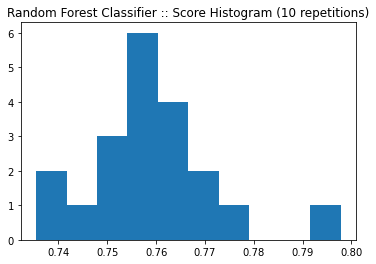

In [712]:
plt.title(f'Random Forest Classifier :: Score Histogram ({rf_clf_kf_repetitions} repetitions)')
plt.hist(rf_clf_score_results)

## Improving the model by using other variables

In [713]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Binary_Sex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [714]:
variables = ['Binary_Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare'] # Columns that will serve as base for our predictions

X = train[variables] 
y = train['Survived'] # Column that we want to predict

X_test = test[variables]

### Cleaning up the data

In [715]:
X = X.fillna(-1)
X_test = X_test.fillna(-1)

In [716]:
rf_clf_many_vars_score_kfold = random_forest_classifier_kfold(X)

Train: 445
Test: 446

Precision: 0.7869955156950673

Train: 446
Test: 445

Precision: 0.7797752808988764

Train: 445
Test: 446

Precision: 0.827354260089686

Train: 446
Test: 445

Precision: 0.8179775280898877

Train: 445
Test: 446

Precision: 0.7847533632286996

Train: 446
Test: 445

Precision: 0.7842696629213484

Train: 445
Test: 446

Precision: 0.8161434977578476

Train: 446
Test: 445

Precision: 0.7842696629213484

Train: 445
Test: 446

Precision: 0.8004484304932735

Train: 446
Test: 445

Precision: 0.8

Train: 445
Test: 446

Precision: 0.8183856502242153

Train: 446
Test: 445

Precision: 0.802247191011236

Train: 445
Test: 446

Precision: 0.8116591928251121

Train: 446
Test: 445

Precision: 0.8067415730337079

Train: 445
Test: 446

Precision: 0.820627802690583

Train: 446
Test: 445

Precision: 0.7887640449438202

Train: 445
Test: 446

Precision: 0.8385650224215246

Train: 446
Test: 445

Precision: 0.8044943820224719

Train: 445
Test: 446

Precision: 0.7982062780269058

Train: 446


### Comparing the two models

In [717]:
print(f"Random Forest Classifier (Two Variables - Sex and Age) :: Score (Using K-Fold Cross-Validation) {rf_clf_two_vars_score_kfold}")
print(f"Random Forest Classifier (Many Variables) :: Score (Using K-Fold Cross-Validation) {rf_clf_many_vars_score_kfold}")

Random Forest Classifier (Two Variables - Sex and Age) :: Score (Using K-Fold Cross-Validation) 0.759601451100922
Random Forest Classifier (Many Variables) :: Score (Using K-Fold Cross-Validation) 0.8041457147175896


## Training the model again with more data

We are going to submit the prediction using the whole dataset to train our model, for that we don't need to split into X_train and y_train like we when evaluating.

In [718]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
rf_clf.fit(X, y) # Getting the whole dataset to train

predictions = rf_clf.predict(X_test)

### Creating the submission to Kaggle

In [719]:
submission = pd.Series(predictions, index=test['PassengerId'], name='Survived')
submission.shape

(418,)

In [720]:
submission.to_csv('result/random_forest_classifier.csv', header=True)